## **RADI608: Data Mining and Machine Learning**

### Assignment: Semi-Supervised Learning
**Romen Samuel Rodis Wabina** <br>
Student, PhD Data Science in Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine (Ramathibodi Hospital) <br>
Mahidol University

Note: In case of Python Markdown errors, you may access the assignment through this GitHub [Link](https://github.com/rrwabina/RADI608/tree/main/Submitted)

##   <code>Question 1</code>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report, confusion_matrix
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from time import time
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

import random
import warnings
warnings.filterwarnings('ignore')

rng = np.random.RandomState(10)

### Question 1a. From <code>colon.csv</code>, please reduce data dimension by using 2 features (column’s name or gene#: <code>T62947</code> and <code>H64807</code>).

We created a function called <code>load_colon</code> to acquire colon data with the relevant gene numbers and its corresponding labels. We then converted it to a numpy array and returns as <code>X</code> and <code>y</code> for the model features and labels, respectively. The function <code>load_colon</code> will also be used in the later questions. 

In [2]:
def load_colon(path = '../data/colon.csv'):
    colon_data = pd.read_csv(path)
    X = colon_data[['T62947', 'H64807']].to_numpy()
    y = colon_data[['Class']].to_numpy()
    return X, y 
X, y = load_colon()

### Question 1b. Generate labeled and unlabeled data by random selecting 42 samples without replacement and removing their class to perform as unlabeled data. The non-selected 20 samples will be used as labeled data (42:20).

We also created the function <code>generate_labeled</code> that requires the dataset from <code>load_colon</code>, including the percentage of samples to be converted into unlabeled data. For this example, we inputted a <code>68%</code> unlabeled data, i.e., 42 samples. This function returns the non-selected 20 samples as labeled data. However, it will return both labeled and unlabeled data once <code>include_unlabeled = True</code>. 

In [3]:
def generate_labeled(X, y, rate = 0.68, include_unlabeled = False, include_neg = False):
    random.seed(30)
    size = int(np.round(X.shape[0] * rate))
    index = random.sample(range(len(y)), size)
    labeled = random.sample([x for x in range(X.shape[0]) if x not in index], X.shape[0] - size)
    X_labeled, y_labeled = X[labeled], y[labeled]

    assert X_labeled.shape[0] == y_labeled.shape[0]

    if include_unlabeled == True:
        X_unlabel, y_unlabel = X, y.copy()
        if include_neg == True:
            y_unlabel[index] = -1
        else:
            y_unlabel[index] = 0
        return X_labeled, y_labeled, X_unlabel, y_unlabel 
    return X_labeled, y_labeled

X_labeled, y_labeled = generate_labeled(X, y, rate =  0.68)

### Question 1c. Perform SVM by using 20 labelled samples.

In this code, the SVM model was trained using a function we created called <code>svm_train</code> that requires the dataset <code>X</code> and <code>y</code>. We used the results of the tuned parameters <code>C</code> and <code>gamma</code> from the previous assignment to train the SVM classifier. The function also prints the resulting <code>classification_report</code> of the ground truth versus model predictions.

In [4]:
def svm_train(X, y, target_names = ['No Cancer', 'Cancer']):
    assert X_labeled.shape[0] == y_labeled.shape[0]
    random.seed(413)
    svclassifier = SVC(kernel = 'rbf', C = 100, gamma = 1)
    svclassifier.fit(X, y)
    predictions = svclassifier.predict(X)
    print(classification_report(y, predictions, target_names = target_names))
    return svclassifier

svclassifier = svm_train(X_labeled, y_labeled)

              precision    recall  f1-score   support

   No Cancer       1.00      1.00      1.00        11
      Cancer       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



### Question 1d. Perform Label Propagation at label spreading 30%, 50%, and 70%. Random replace the original 62 samples.

Prior to Label Spreading, we created the function <code>label_propagate</code> since we will also use this function for Question 2. This function requires the dataset <code>X</code> and <code>y</code> and its corresponding <code>rate</code> of Label Propagation as given in the problem above. We performed label propogation at label spreading <code>30%, 50%, </code> and <code>70%</code>.

In [5]:
def label_propagate(X, y, rate):
    y_new = np.copy(y)
    y_new[rng.rand(len(y)) < rate] = 0
    ls_ix = (LabelSpreading().fit(X, y_new), y_new)
    ls_ix = (ls_ix[0], ls_ix[1].ravel())
    return y_new, ls_ix

y30, ls30 = label_propagate(X, y, rate = 0.30)
y50, ls50 = label_propagate(X, y, rate = 0.50)
y75, ls70 = label_propagate(X, y, rate = 0.70)

rbf_svc = (SVC(kernel = 'rbf', C = 100, gamma = 1).fit(X, y), y)

### Question 1e. Compare and discuss the model performance from <code>Question 1c</code> and <code>Question 1d</code> by plotting two-dimension graph with decision boundary.

We created three Python functions for this question. The <code>plot_contour</code> displays the scatter plot of the two features between two classes, including the decision boundary of the two classes. This function requires the SVM classifier to create the decision boundary by training the SVM model. Meanwhile, the function <code>lsvm_plot</code> is primarily used to plot the three SVM models with label propagation and a single SVM with RBF kernel. The <code>lsvm_plot</code> utilizes the function <code>get_colors</code> to create varying colors for the predicted labels. 

In [6]:
def plot_contour(X, y, svm, title = 'Question 1c'):
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    points = np.c_[xx.ravel(), yy.ravel()]
    Z = svm.predict(points)
    Z = Z.reshape(xx.shape)
    plt.figure(figsize = (6, 4))
    plt.contourf(xx, yy, Z, cmap = plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c = y, s = 70, cmap = plt.cm.plasma, edgecolors = 'black')
    plt.title(title, size = 20)

def get_colors(y_list):
    colors = []
    for y in y_list:
        if   y == -1:
            color = (1, 1,  1)
        elif y ==  0:
            color = (1, 0.1, 0.5)
        elif y ==  1:
            color = (1, 1, 0)
        colors.append(color)
    return colors

def lsvm_plot(ls30, ls50, ls70, rbf_svc):
    x_min, x_max = X[:, 0].min() -1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() -1, X[:, 1].max() + 1

    h = 0.02
    titles = [  'Label Spreading 30% data', 'Label Spreading 50% data', 
                'Label Spreading 70% data', 'SVC with RBF Kernel']

    plt.figure(figsize = (13, 9))
    for i, (clf, y_train) in enumerate((ls30, ls50, ls70, rbf_svc)):
        plt.subplot(2, 2, i + 1)
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.subplots_adjust(wspace = 0.02, hspace = 0.2)
        plt.contourf(xx, yy, Z, cmap = plt.cm.Paired)
        plt.axis('off')
        plt.scatter(X[:, 0], X[:, 1], s = 70, c = get_colors(y_train), edgecolors = 'black')
        plt.title(titles[i], size = 15)
    plt.suptitle('Question 1d: Label Propagation at Different Spread Percentages', size = 20)
    plt.show()

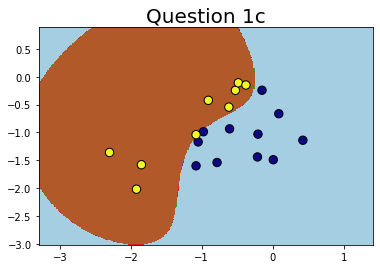

In [7]:
plot_contour(X_labeled, y_labeled, svclassifier)

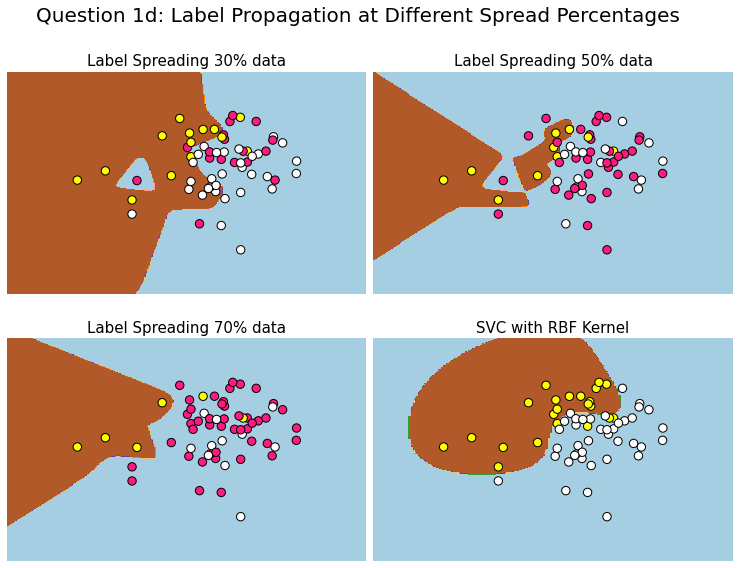

In [8]:
lsvm_plot(ls30, ls50, ls70, rbf_svc)

Let's first denote the following models as SVM20, LS30, LS50, LS70, and SVMRBF as the SVM with 20 labeled datasets, label propagation at spreads 30%, 50%, 70%, and the SVC with RBF kernel, respectively.

The <code>SVM20</code> model has perfectly classified all the twenty samples within their respective boundaries. Results have shown that it obtained a hundred percent evaluation metrics for F1-score. However, its accuracy may be a false pretense since its dataset are misbalanced since it cannot distinguish between the numbers of correctly classified examples of different classes. Hence, it may lead to erroneous conclusions. 

The <code>LS30</code> obtained misclassifications among its predictions.


## <code>Question 2</code>

### Question 2a. Please select one dataset from a UCI  and reduce data dimension by using only 2 features.

In [30]:
def convert_binary(df, columns = ['Risk1Yr']):
    for column in columns:
        df[column] = df[column].apply(lambda x: 0 if x == 'F' else 1)
    return df

def load_thoracic(path = '../data/ThoraricSurgery.csv'):
    data = pd.read_csv(path)
    data = data[['PRE4', 'PRE5', 'Risk1Yr']]
    data = convert_binary(data, columns = ['Risk1Yr'])
    X, y = data[['PRE4', 'PRE5']], data['Risk1Yr']
    X, y = X.to_numpy(), y.to_numpy()
    return X, y

X, y = load_thoracic()
scaler = StandardScaler().fit(X, y)

### Question 2b. Generate labeled and unlabeled data by random selecting 68% of samples without replacement and removing their class to perform as unlabeled data.

The non-selected 32% of samples will be used as labeled data

In [31]:
X_labeled, y_labeled = generate_labeled(X, y, rate = 0.68, include_neg = True)

### Question 2c. Perform SVM by using 20 labelled samples.

In [32]:
svclassifier = svm_train(X_labeled, y_labeled, target_names = ['Surgery Risk', 'No Surgery Risk'])

                 precision    recall  f1-score   support

   Surgery Risk       0.88      1.00      0.94       131
No Surgery Risk       1.00      0.05      0.10        19

       accuracy                           0.88       150
      macro avg       0.94      0.53      0.52       150
   weighted avg       0.89      0.88      0.83       150



### Question 2d. Perform Label Propagation at label spreading 30%, 50%, and 70%.

In [33]:
y30, ls30 = label_propagate(X, y, rate = 0.30)
y50, ls50 = label_propagate(X, y, rate = 0.50)
y75, ls75 = label_propagate(X, y, rate = 0.75)

rbf_svc = (SVC(kernel = 'rbf', gamma = 0.5).fit(X, y), y)

### Question 2e. Compare and discuss the model performance from Questions 2c and 2d.

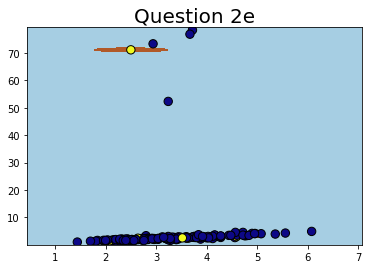

In [34]:
plot_contour(X_labeled, y_labeled, svclassifier, title = 'Question 2e')

## <code>Question 3</code>

#### From <code>colon.csv</code>, please reduce data dimension by using 2 features (column’s name or gene numbers: <code>T62947</code> and <code>H64807</code>).

We utilized the <code>load_colon</code> function from Question 1 to load the colon dataset, reduce data dimension using the two features indicated above, and convert the dataframe into a NumPy array..

In [14]:
X, y = load_colon()

The <code>Questions 3b - 3d</code> requires us to create three models with varying assumptions. All of these models used <code>SMOTE</code> as a resampling strategy and <code>DecisionTreeClassifier()</code> as the classification model for this task. However, it varies whether the model uses <code>undersampling</code> or <code>grid search</code>. To provide a comprehensive code, we created the function <code>main()</code> that requires parameters on the dataset <code>X</code>, <code>y</code>, and boolean values whether to include grid search and undersampling. Under <code>main()</code>, we utilized <code>create_decisiontree</code> and <code>validation</code> functions. The <code>create_decisiontree</code> initializes the required pipeline for a given problem while the <code>validation</code> is used for cross validation.

In [15]:
def create_decisiontree(X, y, include_under = False, k = 2):
    smote = SMOTE(sampling_strategy = 1, k_neighbors = k)
    model = DecisionTreeClassifier()
    under = RandomUnderSampler(sampling_strategy = 1)

    if include_under == True:
        steps = [('over', smote), ('under', under), ('model', model)]
    else:
        steps = [('over', smote), ('model', model)]
    pipeline = Pipeline(steps = steps)
    return pipeline

def validation(X, y, pipeline, k):
    start = time()
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(pipeline, X, y, scoring = 'roc_auc', cv = cv, n_jobs = -1)
    print(f'Mean ROC-AUC at k = {k}: {np.round(mean(scores), 3)}')
    print(f"\t Fit and predict time: {np.round(time() - start, 3)} seconds")

def main(X, y, include_grids = False, include_under = False):
    kvalues = np.arange(1, 8) if include_grids is True else [7]
    for k in kvalues:
        pipeline = create_decisiontree(X, y, include_under, k = k)
        validation(X, y, pipeline, k)

#### Question 3b. Use a <code>SMOTE</code> transformed version of the dataset + <code>DecisionTreeClassifier</code>

In [26]:
main(X, y, include_grids = False, include_under = False)

Mean ROC-AUC at k = 7: 0.754
	 Fit and predict time: 0.087 seconds


#### Question 3c. Use a <code>SMOTE</code> transformed version of the dataset combined with <code>undersampling</code> of the majority class + <code>DecisionTreeClassifier</code>

In [27]:
main(X, y, include_grids = False, include_under = True)

Mean ROC-AUC at k = 7: 0.781
	 Fit and predict time: 0.115 seconds


#### Question 3d. Use a <code>SMOTE</code> transformed version of the dataset combined with <code>undersampling</code> of the majority class + <code>grid search</code> k value for SMOTE oversampling for imbalanced classification + <code>DecisionTreeClassifier</code>

In [29]:
main(X, y, include_grids = True, include_under = True)

Mean ROC-AUC at k = 1: 0.783
	 Fit and predict time: 0.107 seconds
Mean ROC-AUC at k = 2: 0.792
	 Fit and predict time: 0.107 seconds
Mean ROC-AUC at k = 3: 0.779
	 Fit and predict time: 0.087 seconds
Mean ROC-AUC at k = 4: 0.739
	 Fit and predict time: 0.113 seconds
Mean ROC-AUC at k = 5: 0.776
	 Fit and predict time: 0.103 seconds
Mean ROC-AUC at k = 6: 0.819
	 Fit and predict time: 0.1 seconds
Mean ROC-AUC at k = 7: 0.803
	 Fit and predict time: 0.093 seconds


#### Question 3e. Compare and discuss the models performance

Let's denote the models from question 3b, 3c, and 3d as model A, B, and C, respectivey, for clarity. All models utilized a SMOTE transformed version of the dataset with Decision Tree as its classifier. We adopted the AUC-ROC metrics through <code>cross_val_score</code> to evaluate and compare each model. This metric trains and tests a model over multiple folds of the dataset with AUC-ROC as its scoring metric.

The <code>Model A</code> does not utilize any undersampling of the majority class and grid search. However, we utilized <code>k = 7</code> for <code>Model A</code>, i.e., that is, the number of nearest neighbours to be used to construct synthetic samples. Results have shown that <code>Model A</code> generated a mean ROC-AUC of 78.60%, which was trained at only 0.214 seconds. Oversampling using SMOTE not only increases the size of the training dataset, it also increase the variety. Hence, it often results to overfitting. 

The <code>Model B</code> used **random undersampling** of the majority class with similar number of nearest neighbors in <code>Model A</code>. Results have shown that <code>Model B</code> generated an ROC-AUC score of 0.789 at 0.075 seconds. The combination of SMOTE with undersampling techniques has slightly increased the effectiveness of handling the imbalanced class than in <code>Model A</code>. The SMOTE creates a synthetic class samples of the minority class to balance the distribution. The undersampling technique then is used for cleaning irrelevant points in the boundary of the two classes to increase the separation between its classes. This highlights that both the amount of oversampling and undersampling performed and the number of examples selected from which a partner is chosen to create a synthetic example may be important parameters to select and tune the dataset.